# BiLSTM_noChannel4 model

In this notebook we trained the BiLSTM_noChannel4 model using the training and validation set created during preprocessing.

We have that channel 4 is strongly correlated with the other channels.
By not considering it we obtain a slight improvement in classification

But then, by trying to remove other channels as well, the result does not improve. There are other correlations as well, but we'll only remove channel 4 here.

## Initialization

On Colab upload manually the file `dataset.zip`

In [6]:
!unzip -o dataset.zip

Archive:  dataset.zip
  inflating: x_train.npy             
  inflating: y_train.npy             
  inflating: x_train_ov.npy          
  inflating: y_train_ov.npy          
  inflating: x_val.npy               
  inflating: y_val.npy               


### Import libraries

In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing as sklp
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [3]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 135 kB 6.5 MB/s 
     |████████████████████████████████| 1.6 MB 53.4 MB/s 


### Set seed for reproducibility

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load dataset

In [7]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

x_val = np.load("x_val.npy")
y_val = np.load("y_val.npy")

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1938, 36, 6), (491, 36, 6), (1938, 12), (491, 12))

## Model

In [8]:
input_shape = x_train.shape[1:]
classes = 12
batch_size = 128
epochs = 200
input_shape, classes


((36, 6), 12)

### custom layer

### Definition

In [9]:
##funzionante
def build_BiLSTM_no4(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    c0 = tfkl.Lambda(lambda x : x[:,:,0])(input_layer)[...,np.newaxis]
    c1 = tfkl.Lambda(lambda x : x[:,:,1])(input_layer)[...,np.newaxis]
    c2 = tfkl.Lambda(lambda x : x[:,:,2])(input_layer)[...,np.newaxis]
    c3 = tfkl.Lambda(lambda x : x[:,:,3])(input_layer)[...,np.newaxis]## il channel 4 è questo (l'indice parte da 0)
    c4 = tfkl.Lambda(lambda x : x[:,:,4])(input_layer)[...,np.newaxis]
    c5 = tfkl.Lambda(lambda x : x[:,:,5])(input_layer)[...,np.newaxis]

    

    #PATH1
    # Feature extractor
    channel_filter = tfkl.Concatenate()([c0,c1,c2,c4,c5])
    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(channel_filter)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(64, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Return the model
    return model

### Build

In [10]:
model = build_BiLSTM_no4(input_shape, classes)
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 36)           0           ['Input[0][0]']                  
                                                                                                  
 lambda_1 (Lambda)              (None, 36)           0           ['Input[0][0]']                  
                                                                                                  
 lambda_2 (Lambda)              (None, 36)           0           ['Input[0][0]']                  
                                                                                              

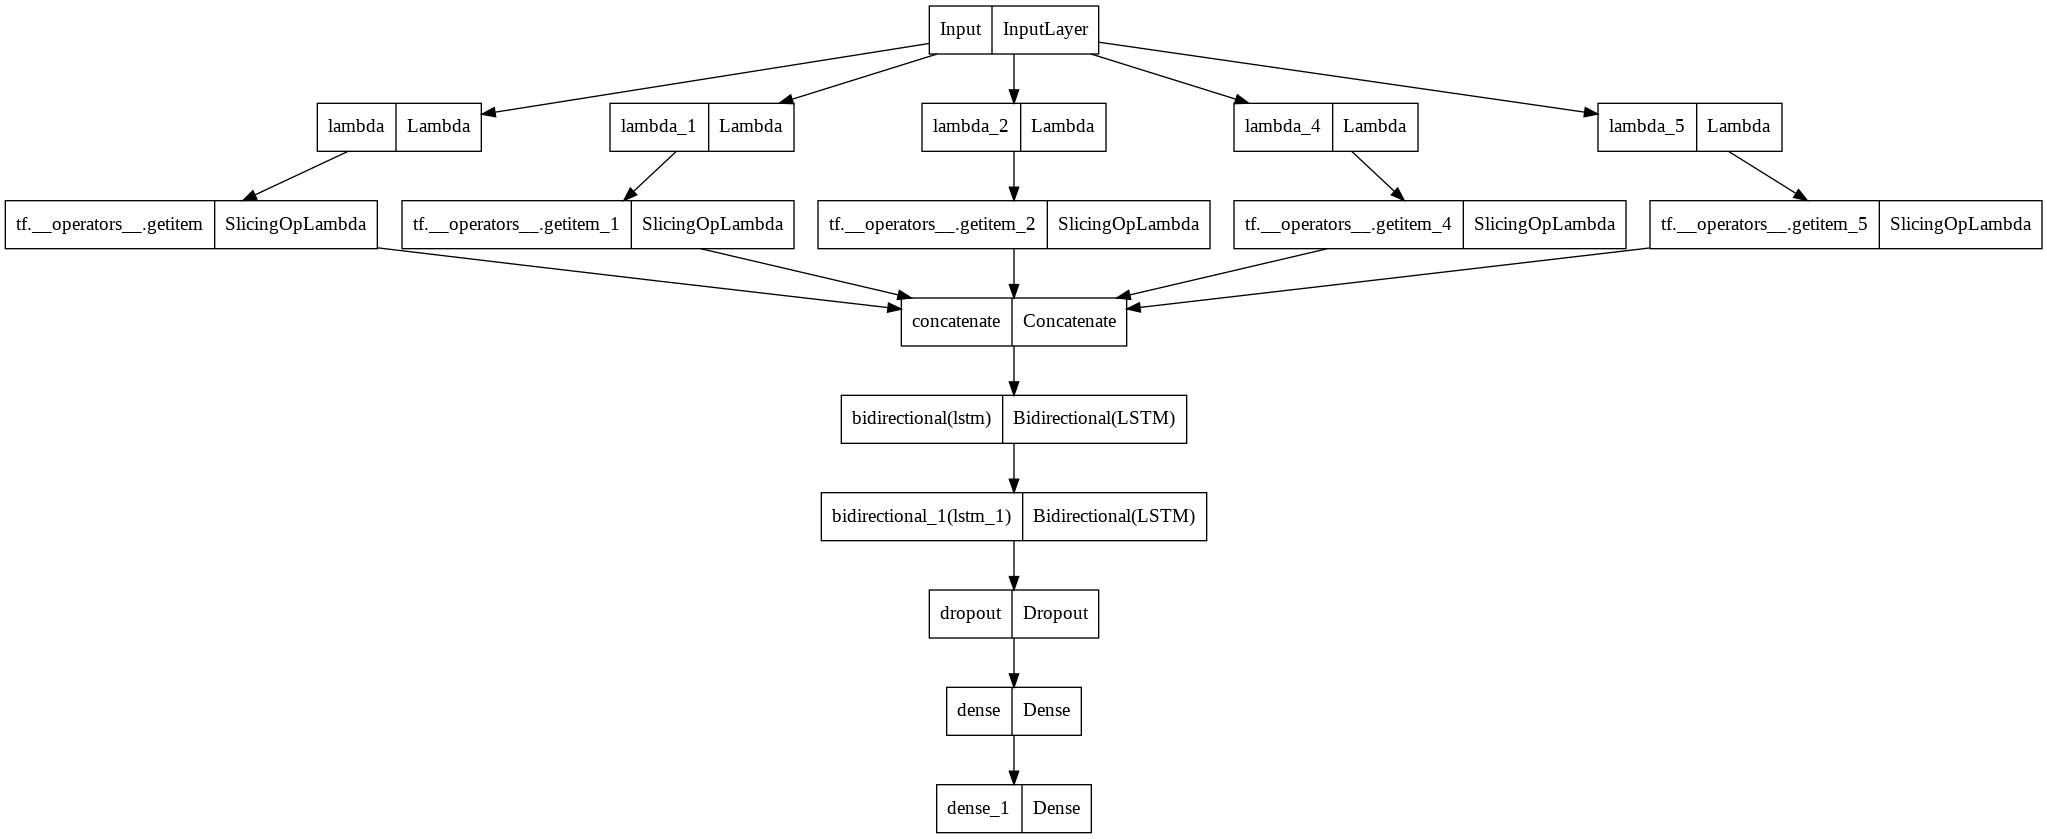

In [11]:
tfk.utils.plot_model(model)

## Traininig

In [13]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, verbose = True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=4, mode='auto',verbose=1, factor=0.01, min_lr=1e-12)
    ]
).history

Epoch 1/200
16/16 [==============================] - 16s 132ms/step - loss: 2.1139 - accuracy: 0.3406 - val_loss: 1.7137 - val_accuracy: 0.4481 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 0s 21ms/step - loss: 1.5713 - accuracy: 0.4778 - val_loss: 1.4000 - val_accuracy: 0.5214 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 0s 17ms/step - loss: 1.2889 - accuracy: 0.5650 - val_loss: 1.2350 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 0s 18ms/step - loss: 1.1097 - accuracy: 0.6342 - val_loss: 1.1767 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 0s 18ms/step - loss: 0.9943 - accuracy: 0.6558 - val_loss: 1.1586 - val_accuracy: 0.6130 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 1s 36ms/step - loss: 0.8871 - accuracy: 0.7069 - val_loss: 1.0930 - val_accuracy: 0.6334 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 1s 40ms/step - 

### Results

In [14]:
target_categories = {
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine",
}

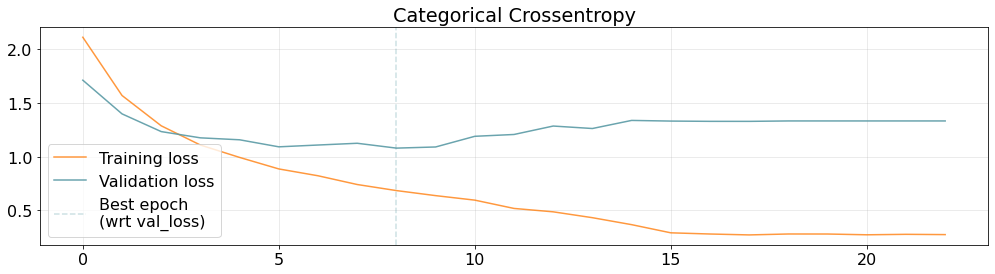

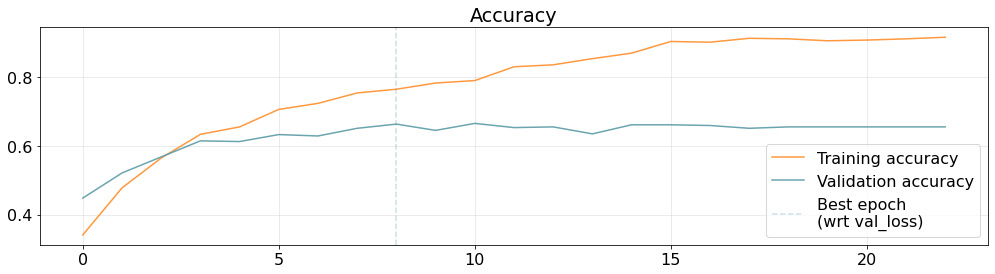

In [15]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch\n(wrt val_loss)', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch\n(wrt val_loss)', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [16]:
model.predict(x_val)

16/16 [==============================] - 1s 7ms/step


(491, 12)

In [17]:
def plot_confusion_matrix(cm, ds_type, labels = list(target_categories.values()) ):
  #cm is a confusion matrix
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

Accuracy: 0.666
Precision: 0.5375
Recall: 0.4765
F1: 0.4744


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


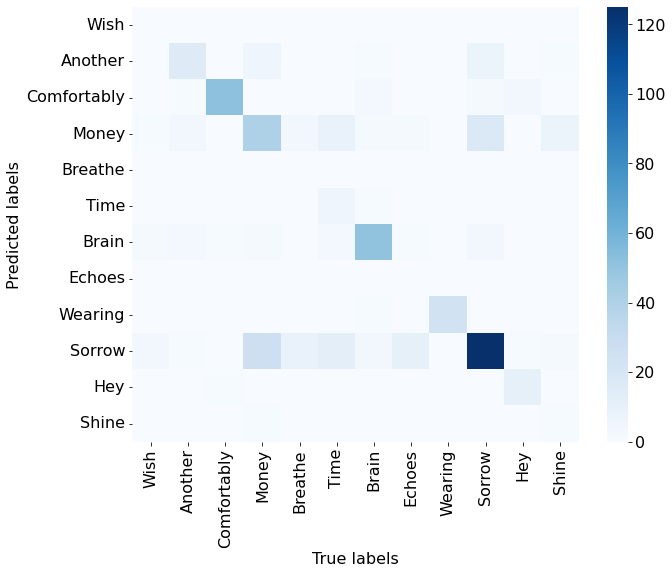

In [18]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(target_categories.values()), yticklabels=list(target_categories.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

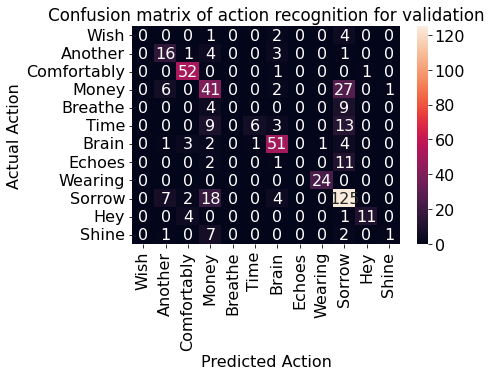

In [19]:
plot_confusion_matrix(cm, 'validation')

### Save

In [20]:
model.save("model")
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 91%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model/variables/variables.index (deflated 69%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 93%)
